# **ST455 PROJECT: DQN for Stock Trading**

Authors: 52998 (nbachorzllado), 23960 (teobruh)

Date: May 2024

## Abstract

In this paper, we investigate the practical use of Deep Q-Networks (DQN) within the complex and turbulent realm of stock trading. We use raw price series from Apple Inc.'s stock in the tumultuous period of the COVID-19 pandemic, in order to demonstrate that DQNs could naturally learn to exploit the nonlinear, non-stationary price dynamics encountered throughout financial markets. We provide empirical evidence of the DQN learning process and the successful deployment by backtesting our model across different horizons and datasets, and show that DQNs significantly outperform simple-buy-and-hold strategy as well as popular trading algorithms. In doing so, we highlight that Deep Reinforcement Learning (DRL) and DQNs can notably support and improve the decision-making in stock trading by automatically learning through raw price movements the optimal actions to achieve the highest rewards.

## 1. Introduction

In this era of modern financial trading systems, the application of advanced machine learning techniques to trading systems has shown increasing interest in both the academic community and the finance industry. Among the most popular learning systems is Deep Q-Networks (DQN), a model-free reinforcement learning algorithm, which is very powerful at acquiring complex decision making policies. We apply DQN to stock trading and particularly, test its performance on trading the stocks of Apple Inc. during the turbulent period driven by the COVID-19 pandemic.

### 1.1 Why DQN?

Deep Q-Networks (DQN) are a class of RL algorithm that merges the standard reinforcement learning paradigm of Q-learning with the representation power of deep neural networks. Such a framework is ideal for stock trading environments, which are high-dimensional and sequential. Below are the main reasons why DQNs are advantageous for stock trading (Li et al., 2019).

Function Approximation: DQNs employ neural networks to approximate the Q-function, which allows them to handle continuous or very large state spaces and generalize to contiguous or unseen states. This is not possible in traditional Q-learning as it requires an explicit discrete Q-table.

Non-linearity: Financial markets are inherently non-linear and DQNs are capable of catching the highly intertwined dynamics of the market which is critical to understand the market and potentially predict market changes.

Experience Replay: We use a memory bank loaded with previous experience to experience replay. This can de-correlate updates and allow the network to learn from a more diverse set of experiences, thus making the trading strategy more robust.

Target Network: DQN comes with a target network to stabilize learning. Financial markets are highly volatile and can disrupt training if learning targets are updated according to the most recent changes in the market.

Altogether, DQNs can learn more adaptive and stable trading strategies that should outperform traditional models, especially in volatile times like what has been present since the COVID-19 pandemic. 

### 1.2 Research Question

Based on the promising capabilities described above, this thesis aims to assess if DQN can live up to its potential under real-world circumstances. In particular, this research focuses on the performance of a DQN-based trading agent applied to Apple Inc. stocks during the most COVID-19 influenced time period. Consequently, the main research question emerges: How well does DQN adapt to the extreme market movements with substantial volatility caused by the Covid-19 outbreak?

To answer this research question, this study aspires to contribute to the practical implications of deep reinforcement learning in financial markets by exploring the extent to which DQN may enrich trading strategies in terms of profitability as well as adaptive ability to market shifts. 


## 2. Data

For this project, we utilized historical adjusted closing prices of Apple Inc. (AAPL) from August 31, 2020, to January 1, 2023, sourced from Yahoo Finance (Yahoo Finance, 2024). This period was chosen because it includes the volatile market conditions triggered by the COVID-19 pandemic, providing a challenging environment for testing the Deep Q-Network (DQN) in stock trading.

The selected timeframe covers significant fluctuations due to the pandemic, making it ideal for evaluating the DQN's performance across different market scenarios. This allows the model to learn and adapt to a variety of conditions, which is crucial for building a robust trading strategy.

We converted the adjusted closing prices into daily percentage changes. This normalization helps highlight the day-to-day returns and reduces scale discrepancies in price data, making it more effective for our model to process and learn from.

In [1]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt

In [2]:
# Function to fetch data from Yahoo Finance, returns daily percentage changes of adjusted close prices.
def fetch_data(ticker, start, end):
    # Download and process data to return only necessary information
    data = yf.download(ticker, start, end)['Adj Close'].ffill().pct_change().dropna()
    return data

# Fetch historical adjusted closing prices for Apple, calculating daily returns.
data = fetch_data('AAPL', '2020-08-31', '2023-01-01')

[*********************100%%**********************]  1 of 1 completed


## 3. Environment

The TradingEnvironment class is designed to simulate a stock trading scenario, commencing operations from the 50th day of the historical dataset. This specific start point is selected to ensure that the environment has access to sufficient past data to compute necessary financial indicators, which are crucial for making informed trading decisions. These indicators include 50-day rolling volatility, moving averages over various periods (5, 12, and 50 days), the Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), and Bollinger Bands, which we see have been useful in similar projects (Babynin, 2020). Each of these metrics offers insights into different aspects of market behavior, such as trend direction, volatility, and trading momentum, which are vital for the strategic decision-making process of the trading agent.

Upon initialization, the environment sets up with an initial cash balance that represents the starting capital for stock trading. Actions within the environment are defined to either buy or sell stock. A buy action, denoted numerically as '1', is executed if there is sufficient cash, leading to an increase in stock holdings and a corresponding reduction in cash reserves. Conversely, a sell action, denoted as '2', reduces stock holdings and increases the cash balance, provided there are stocks to sell. Each action transitions the environment to the next day, updating the stock's value based on the day’s closing price, thus recalculating the total portfolio value (cash plus stock). Choosing the hold action does not require any action on readjusting cash and stocks, but the increase in portfolio value as a result of the next return is again calculated.

The environment's simulation runs until the data's endpoint is reached, with each day's trading resulting in a recalculated portfolio value. The reward function is explicitly defined as the change in portfolio value, offering immediate feedback on the effectiveness of the day's trading action. This setup not only simulates a realistic trading scenario but also provides a structured framework where the DQN model can systematically learn and evaluate different trading strategies under varying market conditions. This structured approach to simulation and the detailed feedback mechanism through the reward function are critical for refining the agent’s trading strategies, ultimately enhancing its decision-making capabilities in a dynamic market environment.

In [3]:
# Define a trading environment class to simulate a stock trading scenario
class TradingEnvironment:
    # Initialize the environment with historical returns and an initial cash balance.
    def __init__(self, returns, balance):
        self.returns = returns
        self.starting_balance = balance
        self.current_day = 49  # Start from day 50 to allow for 50-day metrics
        self.n_days = len(returns)
        self.reset()

    # Reset environment for a new episode
    def reset(self):
        self.current_day = 49  # Reinitialize to day 50
        self.value_stock_owned = 0  # No stock owned initially
        self.cash = self.starting_balance  # Start with initial balance
        self.total_value = self.cash
        return [self._get_observation()], self.total_value

    # Get current market data observation
    def _get_observation(self):
        rolling_volatility = self.returns.rolling(window=50).std()  # 50-day rolling volatility
        fifty_day_volatility = rolling_volatility.iloc[self.current_day]
        fifty_day_mean = self.returns.rolling(window=50).mean().iloc[self.current_day]  # 50-day rolling mean
        twelve_day_mean = self.returns.rolling(window=12).mean().iloc[self.current_day]  # 12-day rolling mean
        five_day_mean = self.returns.rolling(window=5).mean().iloc[self.current_day]  # 5-day rolling mean
        rsi = self.calculate_rsi(14)  # 14-day Relative Strength Index
        macd, macd_signal = self.calculate_macd()  # Moving Average Convergence Divergence
        momentum = self.returns.iloc[self.current_day - 1] - self.returns.iloc[self.current_day - 10]  # 10-day momentum
        upper_band, lower_band = self.calculate_bollinger_bands()  # Bollinger bands
        return [self.returns.iloc[self.current_day], fifty_day_volatility, fifty_day_mean, twelve_day_mean, 
                five_day_mean, rsi, macd - macd_signal, momentum, upper_band, lower_band]

    # Execute a step in the environment based on the agent's action
    def step(self, action):
        # Define actions: 1 for buy, 2 for sell
        if action == 1 and self.cash >= 100:  # Buy
            self.value_stock_owned += 100
            self.cash -= 100
        elif action == 2 and self.value_stock_owned >= 100:  # Sell
            self.value_stock_owned -= 100
            self.cash += 100

        self.current_day += 1  # Move to the next day
        self.value_stock_owned *= (1 + self.returns.iloc[self.current_day])  # Update stock value based on returns
        self.total_value = self.cash + self.value_stock_owned  # Calculate total value

        done = self.current_day + 1 == self.n_days  # Check if the episode is over
        reward = self.total_value - self.starting_balance  # Calculate reward as change in portfolio value
        return [self._get_observation()], reward, done, self.total_value

    # Calculate the Relative Strength Index (RSI)
    def calculate_rsi(self, window):
        delta = self.returns.diff()  # Calculate differences in returns
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Average gains
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Average losses
        rs = gain / loss  # Relative strength
        rsi = 100 - (100 / (1 + rs))  # RSI formula
        return rsi.iloc[self.current_day]

    # Calculate Moving Average Convergence Divergence (MACD) and its signal line
    def calculate_macd(self, short_window=12, long_window=26, signal_window=9):
        exp1 = self.returns.ewm(span=short_window, adjust=False).mean()  # Short-term EMA
        exp2 = self.returns.ewm(span=long_window, adjust=False).mean()  # Long-term EMA
        macd = exp1 - exp2  # MACD line
        signal_line = macd.ewm(span=signal_window, adjust=False).mean()  # Signal line
        return macd.iloc[self.current_day], signal_line.iloc[self.current_day]

    # Calculate Bollinger Bands
    def calculate_bollinger_bands(self, window=20, num_std=2):
        rolling_mean = self.returns.rolling(window=window).mean()  # Rolling mean
        rolling_std = self.returns.rolling(window=window).std()  # Rolling standard deviation
        upper_band = rolling_mean + (rolling_std * num_std)  # Upper Bollinger Band
        lower_band = rolling_mean - (rolling_std * num_std)  # Lower Bollinger Band
        return upper_band.iloc[self.current_day], lower_band.iloc[self.current_day]

## 4. Learning Algorithm

### 4.1 Neural network initialisation

We initiate our approach by setting up the neural network architecture essential for the DQN. The input layer (fc1) receives the state vector from the environment, which encapsulates key financial indicators and the current portfolio status. It translates these inputs into a 64-neuron hidden layer, serving as the first level of abstraction where primary features and relationships are extracted. The second hidden layer (fc2) continues this refinement process with another 64 neurons, intensifying the feature extraction process. The output layer (fc3) is tasked with producing a set of Q-values, one for each possible action, thus providing a direct mapping from state features to estimated future rewards.

In [4]:
# Neural network class to approximate Q-function
class QNetwork(nn.Module):
    # Initialize network layers and seed for reproducibility
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)  # First fully connected layer
        self.fc2 = nn.Linear(64, 64)  # Second fully connected layer
        self.fc3 = nn.Linear(64, action_size)  # Output layer

    # Forward pass through the network
    def forward(self, state):
        x = F.relu(self.fc1(state))  # ReLU activation function for hidden layer 1
        x = F.relu(self.fc2(x))  # ReLU activation function for hidden layer 2
        return self.fc3(x)  # Return action values

### 4.2 Agent class

Here we implement the Dual network and the Experience replay components, our periodic step function is designed to learn every Four steps and a threshold which ensures that 
there is a sufficient batch size to perform meaningful minibatch updates. Our choice of 0.99 as our discount factor indicates that future rewards are almost as valuable as 
immediate rewards, typical in environments such as financial trading. 

The Act Method processes state input by converting the state to a float. The eval() function then disables specific layers and functionalities like dropout or batch 
normalization that behave differently during training versus inference. With gradients calculation disabled using (torch.no_grad()), the network computes the Q-values for all 
possible actions from the current state. Finally an An epsilon-greedy algorithm is used to select the action which chooses the action with the highest Q-value (best action) 
most of the time but randomly selects any action with a probability epsilon.


The Learn Method starts by having the experiences sampled from the replay buffer unpacked into their components: states, actions, rewards, next states, and done flags 
in order to process. For each next state, the target network predicts the Q-values. The maximum Q-value for each next state is selected using detach() to prevent gradient 
flow, representing the best possible future reward. The target Q-values for the current states are calculated using the Bellman equation, only if the episode is not done, as 
indicated by dones. The Mean Squared Error (MSE) loss is computed between these expected Q-values and the target Q-values, quantifying the difference between the currently 
estimated values and the more accurately estimated future values, and the gradients of the loss are calculated and propagated back through the network using loss.backward() 
where the network learns by adjusting its weights to minimize the loss. Finally, the optimizer updates the weights of the local network to reflect the learned changes.

In [5]:
# Agent class to encapsulate state, action logic
class Agent:
    # Initialize agent properties and networks
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)  # Seed for reproducibility
        # Initialize local and target Q-networks
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(torch.device("cpu"))
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(torch.device("cpu"))
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=5e-4)  # Optimizer for training the network
        self.memory = ReplayBuffer(action_size, int(1e5), 64, seed)  # Replay buffer for experience replay
        self.t_step = 0  # Time step counter for updating every few steps

    # Take a step in the environment
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)  # Save experience in replay memory
        self.t_step = (self.t_step + 1) % 4  # Learn every 4 time steps
        if self.t_step == 0 and len(self.memory) > 64:  # If enough samples are available in memory
            experiences = self.memory.sample()  # Get a sample of experiences
            self.learn(experiences, 0.99)  # Learn from experiences

    # Decide action based on state
    def act(self, state, eps=0.):
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0).to(torch.device("cpu"))  # Process state input
        self.qnetwork_local.eval()  # Set local network to evaluation mode
        with torch.no_grad():
            action_values = self.qnetwork_local(state)  # Get action values from network
        self.qnetwork_local.train()  # Set local network back to training mode
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())  # Choose best action
        else:
            return random.choice(np.arange(self.action_size))  # Choose random action

    # Learn from batch of experiences
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences  # Unpack experiences
        # Get max predicted Q values (for next states) from target model
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)  # Compute Q targets for current states
        q_expected = self.qnetwork_local(states).gather(1, actions)  # Get expected Q values from local model
        loss = F.mse_loss(q_expected, q_targets)  # Compute loss
        self.optimizer.zero_grad()  # Clear the gradients
        loss.backward()  # Perform backpropagation
        self.optimizer.step()  # Update the network weights

### 4.3 Replay buffer class

The use of a deque with a maxlen parameter allows the buffer to maintain a fixed size, automatically discarding the oldest experiences when new ones are added. This is to 
avoid local optima where the ReplayBuffer ensures that the agent does not focus too narrowly on recent states and actions, which might be only locally optimal but also phase 
out potentially outdated information. We then add new experience to then randomly sample from our memory, wherein our assumption that for our respective Memory, the sampled 
transitions become asymptotically independent (correlation decays with time), yielding more accurate estimate.

In [6]:
# Replay buffer to store experience tuples
class ReplayBuffer:
    # Initialize replay buffer
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # Fixed-size buffer to store experience tuples
        self.batch_size = batch_size  # Size of each training batch
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)  # Seed for reproducibility

    # Add a new experience to memory
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)  # Add to memory

    # Randomly sample a batch of experiences from memory
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(torch.device("cpu"))
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(torch.device("cpu"))
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(torch.device("cpu"))
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(torch.device("cpu"))
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(torch.device("cpu"))

        return (states, actions, rewards, next_states, dones)

    # Return the current size of internal memory
    def __len__(self):
        return len(self.memory)

### 4.3 Training loop

Train using 500 episodes where the epsiolon Initialisation and Decay is controlled using parametres that ensure we begin with 100% exploration with a decay rate of 0.995 in 
order for the agent to gradually exploit what it has learnt and narrow into an optimal policy. We then start with a balance of $10,000 and collect our results.

In [7]:
# Training loop for reinforcement learning agent
def train_agent(n_episodes=500):
    eps_start = 1.0  # Start with a 100% chance of random action
    eps_end = 0.01  # End with a 1% chance of random action
    eps_decay = 0.995  # Decay rate for epsilon per episode
    scores = []  # List to save the scores for each episode
    final_values = []  # List to save the final values for each episode
    eps = eps_start  # Initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, total_value = env.reset()  # Reset the environment
        score = 0  # Initialize the score
        done = False  # Initialize done
        while not done:
            action = agent.act(state, eps)  # Select an action
            next_state, reward, done, final_value = env.step(action)  # Step the environment
            agent.step(state, action, reward, next_state, done)  # Step the agent
            state = next_state  # Roll over the state to next time step
            score += reward  # Update the score
        scores.append(score)  # Save the score
        final_values.append(final_value)  # Save the final value
        eps = max(eps_end, eps_decay * eps)  # Decrease epsilon
        print(f'Episode {i_episode}, Score: {score}, Final Value: {final_value}, Eps: {eps}')
    return scores, final_values

In [8]:
# Initialize environment and agent with parameters
env = TradingEnvironment(data, 10000)  # Start with a balance of $10,000
agent = Agent(state_size=10, action_size=3, seed=0)  # Three possible actions: hold, buy, sell

# Run training
scores, final_values = train_agent()

Episode 1, Score: 97078.47897323812, Final Value: 9770.798814202855, Eps: 0.995
Episode 2, Score: 48446.48296093147, Final Value: 10015.381989718104, Eps: 0.990025
Episode 3, Score: 86784.27880252476, Final Value: 10026.165105239701, Eps: 0.985074875
Episode 4, Score: 168189.53283786937, Final Value: 10287.443070705338, Eps: 0.9801495006250001
Episode 5, Score: 49294.885766098996, Final Value: 9494.38780405424, Eps: 0.9752487531218751
Episode 6, Score: 71655.09614104606, Final Value: 10067.248063785024, Eps: 0.9703725093562657
Episode 7, Score: 116901.3458504731, Final Value: 10179.473433557583, Eps: 0.9655206468094844
Episode 8, Score: 22842.36346487027, Final Value: 9820.669115707402, Eps: 0.960693043575437
Episode 9, Score: 203293.47678782398, Final Value: 10147.460708339644, Eps: 0.9558895783575597
Episode 10, Score: 174793.9321560704, Final Value: 10297.576604043403, Eps: 0.9511101304657719
Episode 11, Score: 47676.00987587748, Final Value: 9825.011883677915, Eps: 0.94635457981344

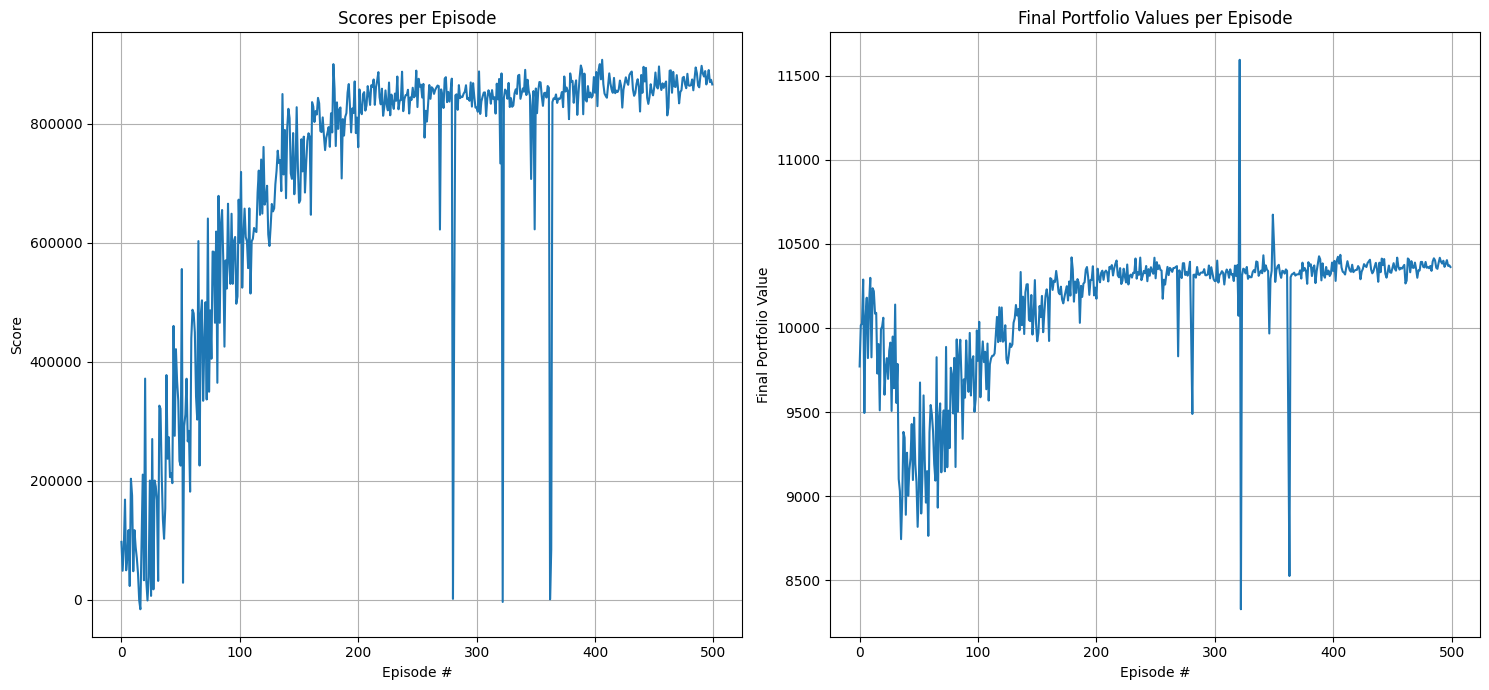

In [9]:
# Plot the scores and final values over episodes
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(scores)
plt.title('Scores per Episode')
plt.xlabel('Episode #')
plt.ylabel('Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(final_values)
plt.title('Final Portfolio Values per Episode')
plt.xlabel('Episode #')
plt.ylabel('Final Portfolio Value')
plt.grid(True)

plt.tight_layout()
plt.show()

### 4.4 Plotted results

The graph shows a general upward trend in the scores per episode, suggesting that the agent is learning effectively over time, the abnormal jolts in progression are most 
likely a result of our agent rapidly performing actions out of order due to changes in volatility that can lead to large swings in rewards. We see that early in training, 
with high epsilon values, the agent explores the action space extensively, leading to high variance in scores and portfolio values as the agent tries out various strategies 
that may or may not lead to success. As epsilon decreases, the agent's actions become more based on learned strategies and we see tighter bounds of progression and potential 
acquiescence towards Apple stock behaviour.

## 5. Out of Sample Testing

Out of sample testing is essential for evaluating the generalization and robustness of the Deep Q-Network (DQN) developed for stock trading. This phase tests the model's effectiveness on new, unseen data, providing a realistic measure of its potential performance in live trading scenarios. It helps confirm that the model can adapt to new market conditions and has not merely memorized the training data.

For a rigorous evaluation, we use Apple Inc.'s stock prices from January 1, 2023, to December 31, 2023, a period immediately following the training data set. This approach ensures that the testing conditions are consistent yet challenging, with fresh data introducing different market dynamics.

In [12]:
# Fetch new out-of-sample data for Apple from a later period
out_of_sample_data = fetch_data('AAPL', '2023-01-01', '2023-12-31')

# Initialize the environment with the new data for testing
test_env = TradingEnvironment(out_of_sample_data, 10000)  # Assuming starting balance as $10,000 for testing

# Function to evaluate the agent on the testing environment
def evaluate_agent(environment, agent, n_episodes=1):
    state, total_value = environment.reset()  # Reset the environment
    done = False
    while not done:
        action = agent.act(state, eps=0)  # Set epsilon to 0 for evaluation (no random actions)
        next_state, reward, done, final_value = environment.step(action)  # Step the environment
        state = next_state
    return final_value

# Evaluate the agent
final_values_test = evaluate_agent(test_env, agent)
print(final_values_test)  # Output final tested values

[*********************100%%**********************]  1 of 1 completed


10976.063374463261


As can be seen, the model employs learned trading strategies and effectively turns an initial investment of \\$10,000 into \\$10,976 over the out-of-sample testing period. This performance demonstrates the model's ability to adapt its trading decisions based on the learned patterns from historical data, even when faced with new and potentially unforeseen market conditions. The increase in portfolio value by nearly 10% suggests that the DQN not only preserved capital but also generated substantial returns, indicating robustness and potential practical applicability in real-world trading scenarios. This outcome reinforces the utility of Deep Q-Networks in developing automated trading systems that can outperform traditional, static strategies even in volatile markets.

## 6. Conclusion and Evaluation

In conclusion, the implementation of a Deep Q-Network (DQN) for trading Apple stock has demonstrated a promising approach to leveraging advanced learning techniques.  in the domain of stock trading. Through analysis of training performance through scores and final portfolio values indicates that the DQN is capable of learning and adapting its strategies over time, achieving acceptable improvements in decision-making as evidenced by the general upward trends and stabilization in portfolio values.

### 6.1 Improvements

The evaluation of our DQN model reveals both its strengths in capturing profits and areas for potential improvement. Future work could focus on enhancing the network architecture, refining the reward structure. Additionally, exploring alternative learning strategies, such as prioritized experience replay or adaptive epsilon decay rates, the adjustment of other parametres  might provide new avenues for optimizing the learning process and achieving more consistent performance.

## References:

Babynin, A. (2020, February 6). Reinforcement learning in Trading (part 2 - the last). Medium. https://andreybabynin.medium.com/reinforcement-learning-in-trading-part-2-the-last-9af547fb4203

Li, Y., Ni, P., & Chang, V. (2019). Application of deep reinforcement learning in stock trading strategies and stock forecasting. Computing, 102(6), 1305–1322. https://doi.org/10.1007/s00607-019-00773-w

Yahoo Finance. (2024). Apple Inc. (AAPL) stock price, news, quote & history – Yahoo Finance. Uk.finance.yahoo.com. https://uk.finance.yahoo.com/quote/AAPL?.tsrc=fin-srch